# [作業目標]
- 使用 Day 17 剛學到的方法, 對較完整的資料生成離散化特徵
- 觀察上述離散化特徵, 對於目標值的預測有沒有幫助

# [作業重點]
- 仿照 Day 17 的語法, 將年齡資料 ('DAYS_BIRTH' 除以 365) 離散化
- 繪製上述的 "離散化標籤" 與目標值 ('TARGET') 的長條圖

In [1]:
# 載入需要的套件
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 設定 data_path
dir_data = 'data/'

### 之前做過的處理

In [7]:
# 讀取資料檔
f_app_train = os.path.join(dir_data, 'application_train.csv')
app_train = pd.read_csv(f_app_train)
app_train.shape

(307511, 122)

In [8]:
# 將只有兩種值的類別型欄位, 做 Label Encoder, 計算相關係數時讓這些欄位可以被包含在內
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# 檢查每一個 column
for col in app_train:
    if app_train[col].dtype == 'object':
        # 如果只有兩種值的類別型欄位
        if len(list(app_train[col].unique())) <= 2:
            # 就做 Label Encoder, 以加入相關係數檢查
            app_train[col] = le.fit_transform(app_train[col])            
print(app_train.shape)
app_train.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,M,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,F,0,0,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,M,1,1,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,F,0,1,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,M,0,1,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# 受雇日數為異常值的資料, 另外設一個欄位記錄, 並將異常的日數轉成空值 (np.nan)
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

# 出生日數 (DAYS_BIRTH) 取絕對值 
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])

## 練習時間
參考 Day 17 範例程式，離散化你覺得有興趣的欄位，並嘗試找出有趣的訊息

In [10]:
app_train['DAYS_BIRTH'] = app_train['DAYS_BIRTH']/365
app_train['DAYS_BIRTH_GROUP'] = pd.cut(app_train['DAYS_BIRTH'], 8)
app_train['DAYS_BIRTH_GROUP'].value_counts().sort_index()

(20.469, 26.593]    19016
(26.593, 32.668]    47520
(32.668, 38.744]    49708
(38.744, 44.819]    51100
(44.819, 50.895]    42340
(50.895, 56.97]     42345
(56.97, 63.045]     37281
(63.045, 69.121]    18201
Name: DAYS_BIRTH_GROUP, dtype: int64

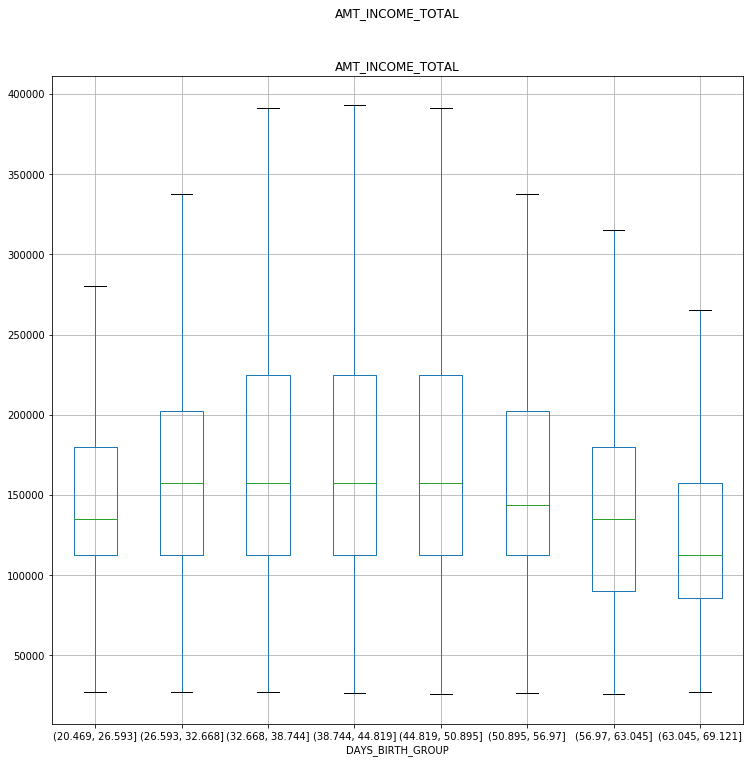

In [12]:
#用boxplot看各年齡層之間的收入差異，發現30~50普遍較有錢，相對貧富差距也拉得更大
#各年齡層25分位差不多，判斷應該是最低薪資附近或有社會津貼？
plt_column = 'AMT_INCOME_TOTAL'
plt_by = 'DAYS_BIRTH_GROUP'
app_train.boxplot(column=plt_column, by = plt_by, showfliers = False, figsize=(12,12))
plt.suptitle('AMT_INCOME_TOTAL')
plt.show()

In [45]:
#嘗試看年齡區間與生還比例的關係，發現越年輕越容易生還...
target_group_by_age = app_train.groupby('DAYS_BIRTH_GROUP', as_index = False)['TARGET'].mean()
target_group_by_age

,DAYS_BIRTH_GROUP,TARGET
0,"(20.469, 26.593]",0.115271
1,"(26.593, 32.668]",0.110038
2,"(32.668, 38.744]",0.094331
3,"(38.744, 44.819]",0.080000
4,"(44.819, 50.895]",0.073335
5,"(50.895, 56.97]",0.063573
6,"(56.97, 63.045]",0.053700
7,"(63.045, 69.121]",0.045492


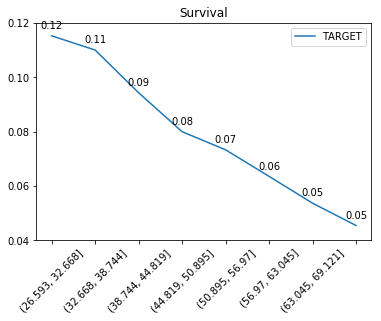

In [71]:
#視覺化越老越不容易生還，生還比例26~32的區間較63~69 高出100%以上
fig = target_group_by_age.plot(x = 'DAYS_BIRTH_GROUP', y = 'TARGET', title = 'Survival', use_index = True) #x = 'DAYS_BIRTH_GROUP'
plt.xlabel('')
fig.set_xticklabels(target_group_by_age['DAYS_BIRTH_GROUP']) 
fig.tick_params(axis = 'x', labelrotation = 45) #tick_params可以設置刻度跟刻度標籤相關


#加個資料標籤
for x,y in zip(range(len(target_group_by_age)), target_group_by_age['TARGET']):

    label = "{:.2f}".format(y)
    plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,15), ha='center', va = 'top')
    

#調整一下y軸刻度
my_y_ticks = np.arange(0.04, 0.13, 0.02)
plt.yticks(my_y_ticks)

plt.show()

#資料標籤參考底下的code
# # zip joins x and y coordinates in pairs
# for x,y in zip(xs,ys):

#     label = "{:.2f}".format(y)

#     plt.annotate(label, # this is the text
#                  (x,y), # this is the point to label
#                  textcoords="offset points", # how to position the text
#                  xytext=(0,10), # distance from text to points (x,y)
#                  ha='center') # horizontal alignment can be left, right or center

# plt.show()


In [ ]:
#畫柱狀圖可以決定距離來畫
sales_pos = [0,1,5]
plt.bar(sales_pos,sales)